In [6]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def plot_val_metric_boxplot(metric_name: str):
    # Ścieżka dwa foldery wyżej
    base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

    # Znajdź foldery zaczynające się od "blur"
    blur_folders = [
        name for name in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, name)) and name.startswith('blur')
    ]

    data = []  # Lista (folder, metric_value)

    # Dla każdego folderu
    for folder in blur_folders:
        folder_path = os.path.join(base_path, folder)
        for fname in os.listdir(folder_path):
            if fname.endswith('val.csv'):
                file_path = os.path.join(folder_path, fname)
                try:
                    df = pd.read_csv(file_path)
                    if metric_name in df.columns:
                        last_value = df[metric_name].dropna().iloc[-1]
                        data.append({'folder': folder, 'metric': last_value})
                except Exception as e:
                    print(f"Błąd przy przetwarzaniu pliku {file_path}: {e}")

    # Tworzenie DataFrame i wykresu
    if not data:
        print("Nie znaleziono żadnych danych do wyświetlenia.")
        return

    df_plot = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='folder', y='metric', data=df_plot)
    plt.title(f'Rozkład końcowych wartości metryki: {metric_name}')
    plt.ylabel(metric_name)
    plt.xlabel('Folder')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

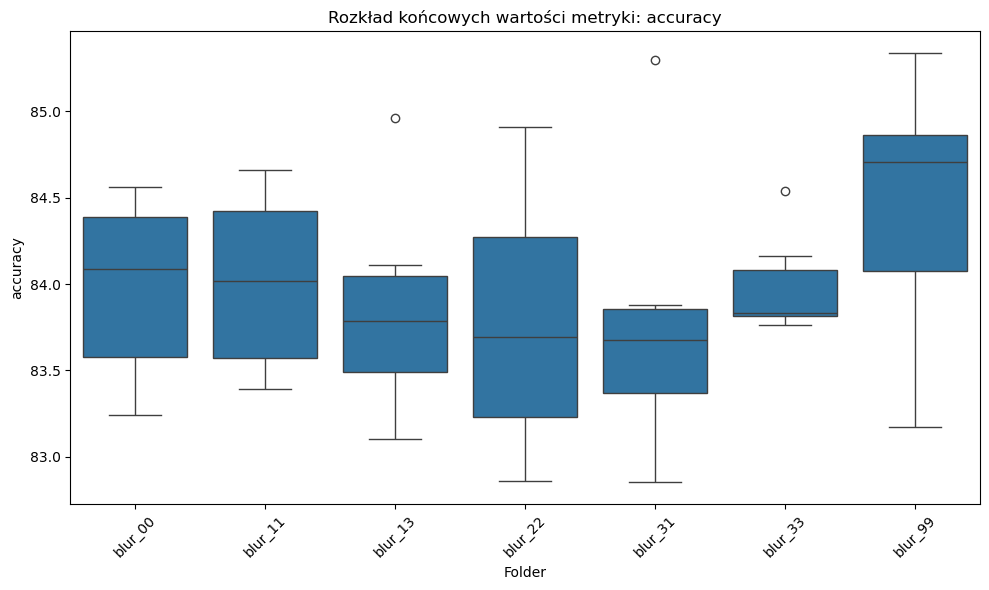

In [8]:
plot_val_metric_boxplot("accuracy")

In [19]:
def plot_metrics_per_augmentation():
    base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    metrics = ['loss', 'accuracy', 'recall', 'precision', 'f1']
    augment_keywords = ['blur', 'brightness', 'flip', 'noise', 'rotate']

    palette = sns.color_palette("Set2", len(metrics))

    for aug in augment_keywords:
        all_data = {metric: [] for metric in metrics}

        for folder in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder)
            if not os.path.isdir(folder_path) or aug not in folder.lower():
                continue

            split_name = folder[-2:]  # ostatnie dwa znaki z nazwy folderu
            for fname in os.listdir(folder_path):
                if fname.endswith('val.csv'):
                    file_path = os.path.join(folder_path, fname)
                    try:
                        df = pd.read_csv(file_path)
                        for metric in metrics:
                            if metric in df.columns:
                                last_value = df[metric].dropna().iloc[-1]
                                all_data[metric].append({
                                    'split': split_name,
                                    'value': last_value
                                })
                    except Exception as e:
                        print(f"Błąd przy przetwarzaniu pliku {file_path}: {e}")

        # Rysowanie wykresu tylko jeśli coś zebrano
        if any(all_data[metric] for metric in metrics):
            fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(22, 5), sharey=False)

            for i, metric in enumerate(metrics):
                df_metric = pd.DataFrame(all_data[metric])
                if not df_metric.empty:
                    sns.boxplot(x='split', y='value', data=df_metric, ax=axs[i], color=palette[i])
                    axs[i].set_title(metric.capitalize(), fontsize=12)
                    axs[i].set_xlabel('Splits')
                    axs[i].tick_params(axis='x', rotation=45)
                else:
                    axs[i].set_visible(False)

            plt.tight_layout()
            plt.suptitle(f"Końcowe wartości metryk walidacyjnych ({aug.capitalize()})", fontsize=16, y=1.05)
            plt.show()

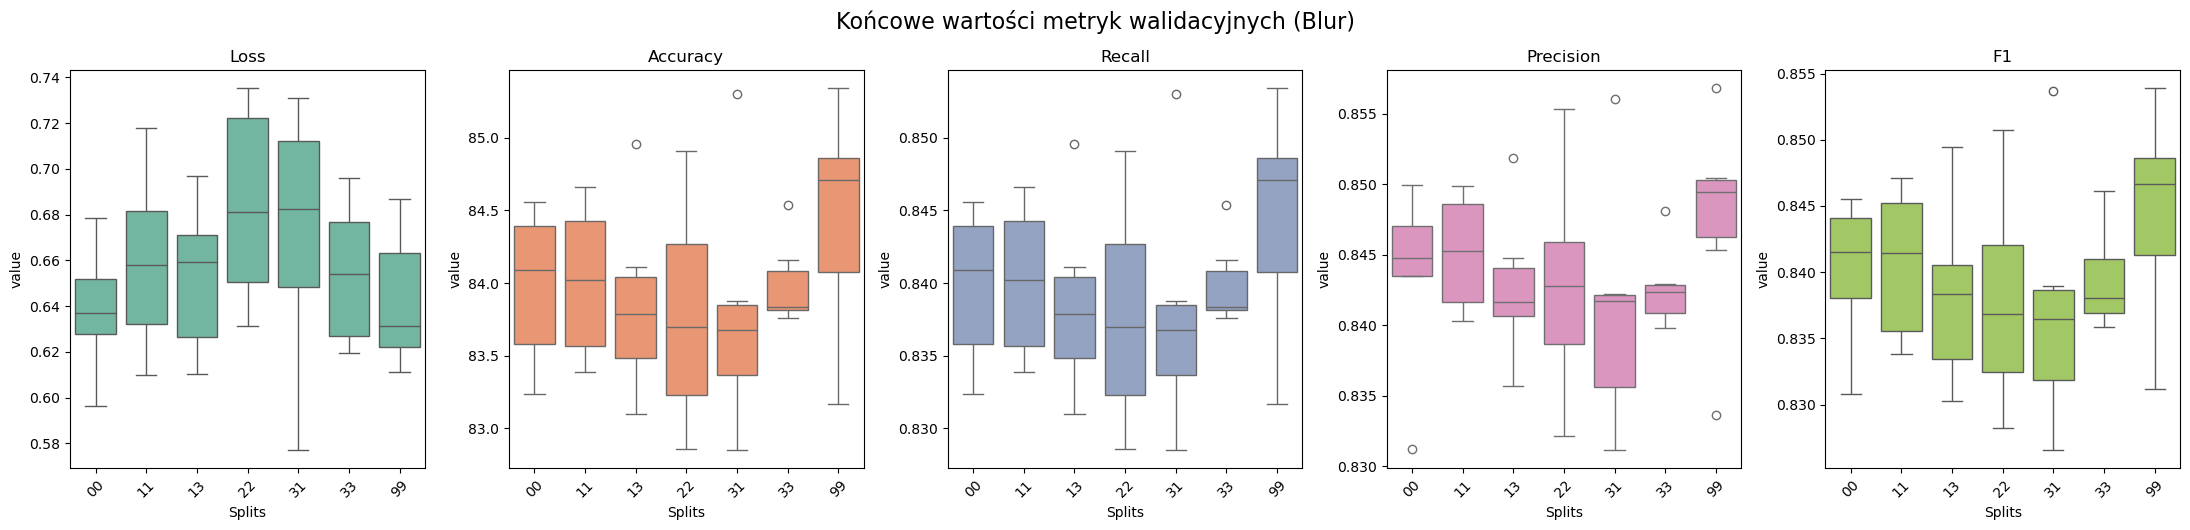

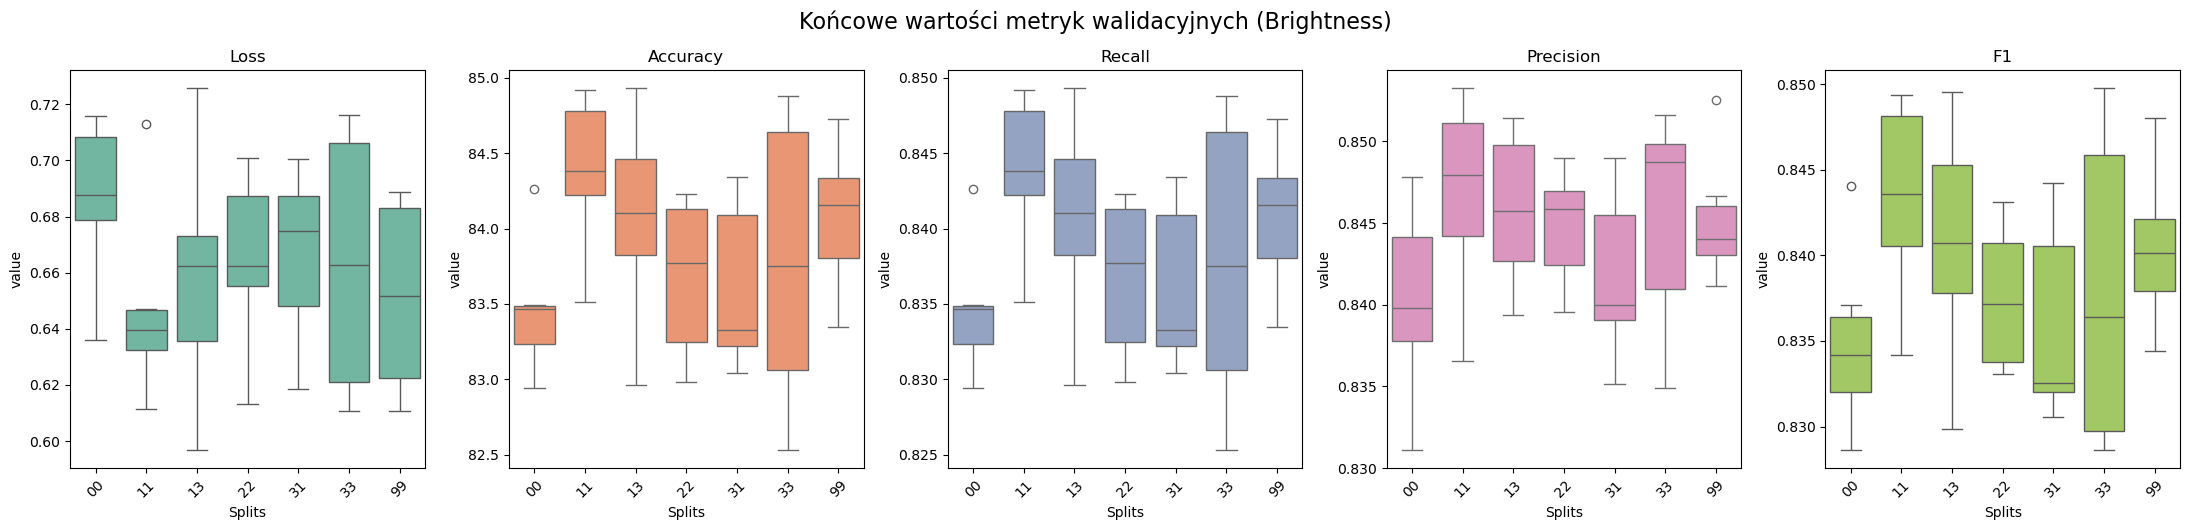

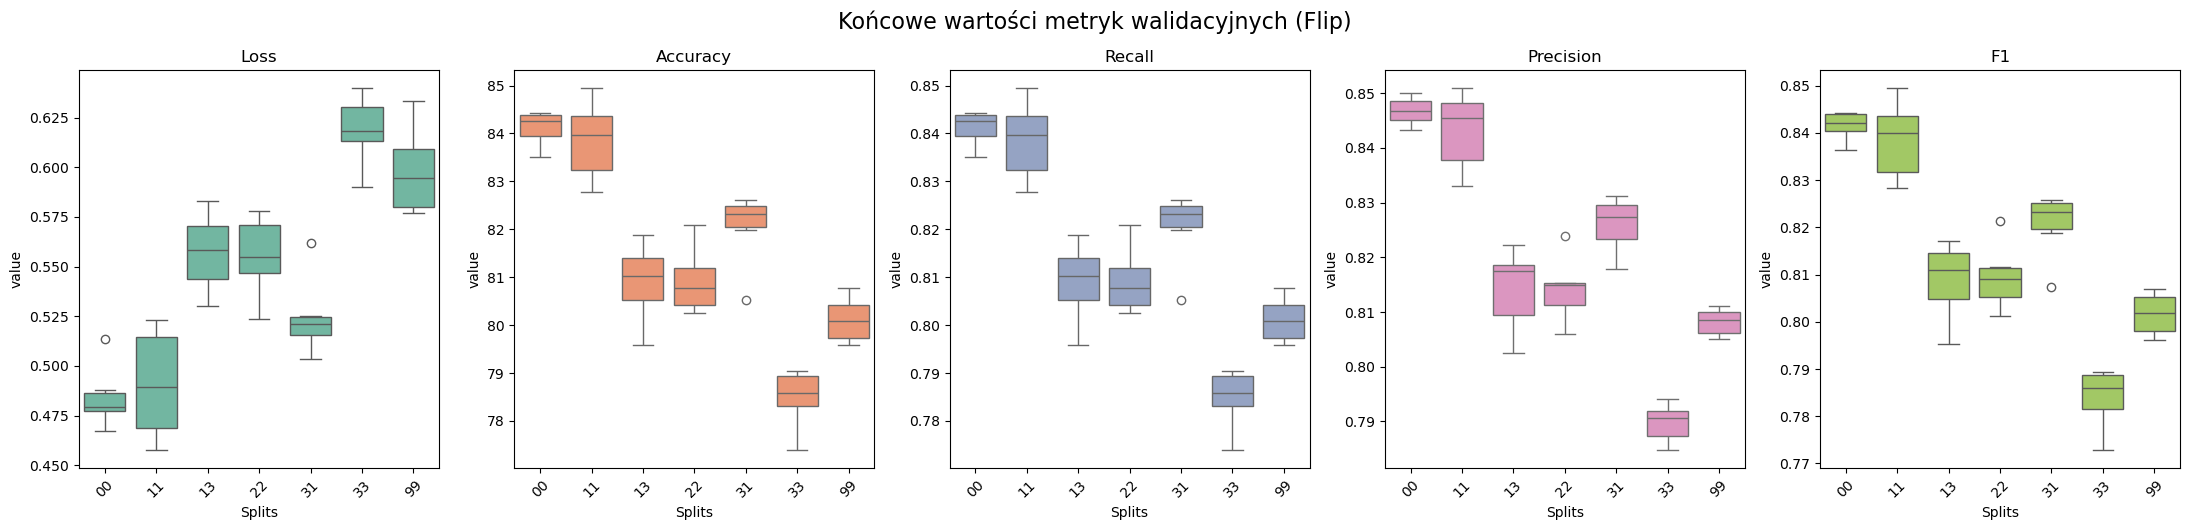

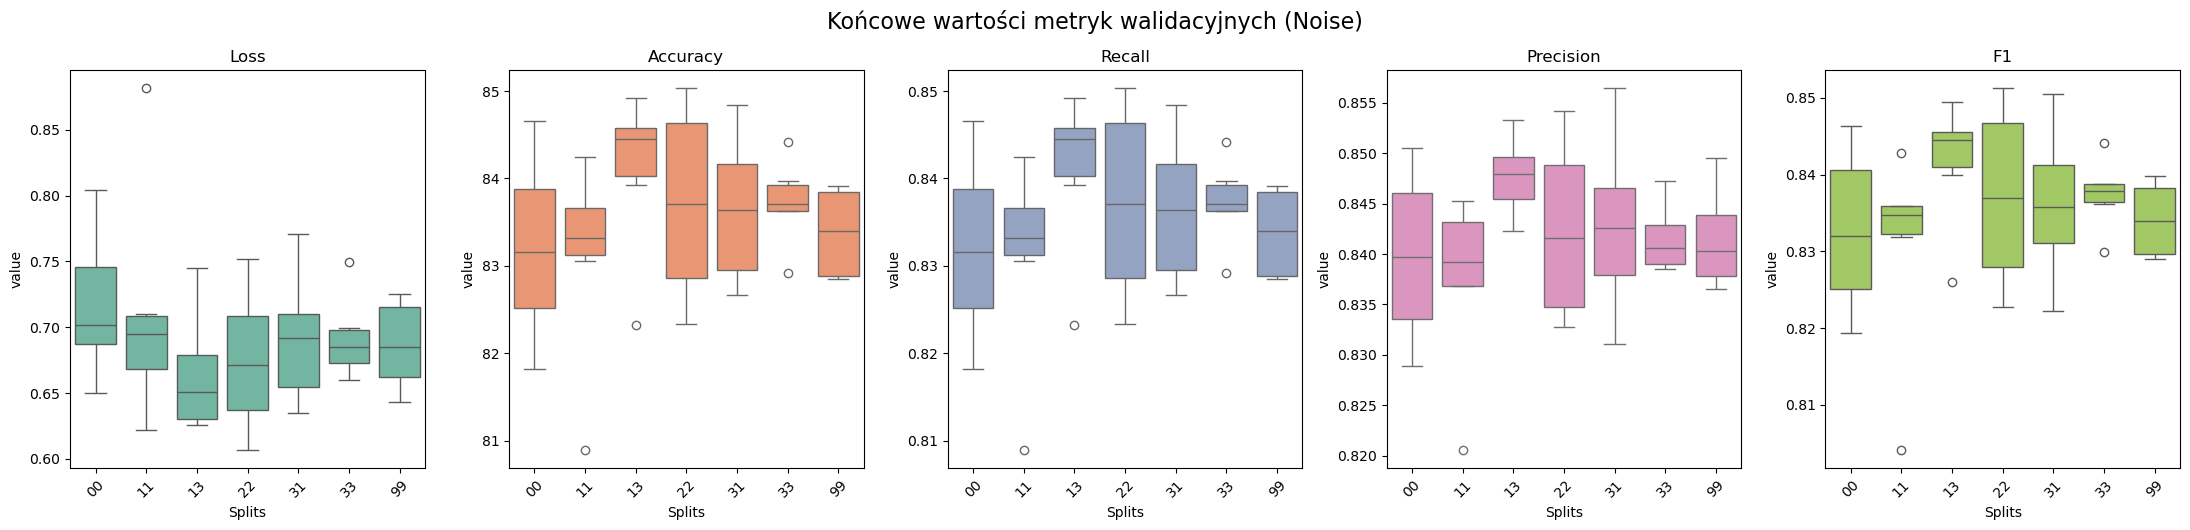

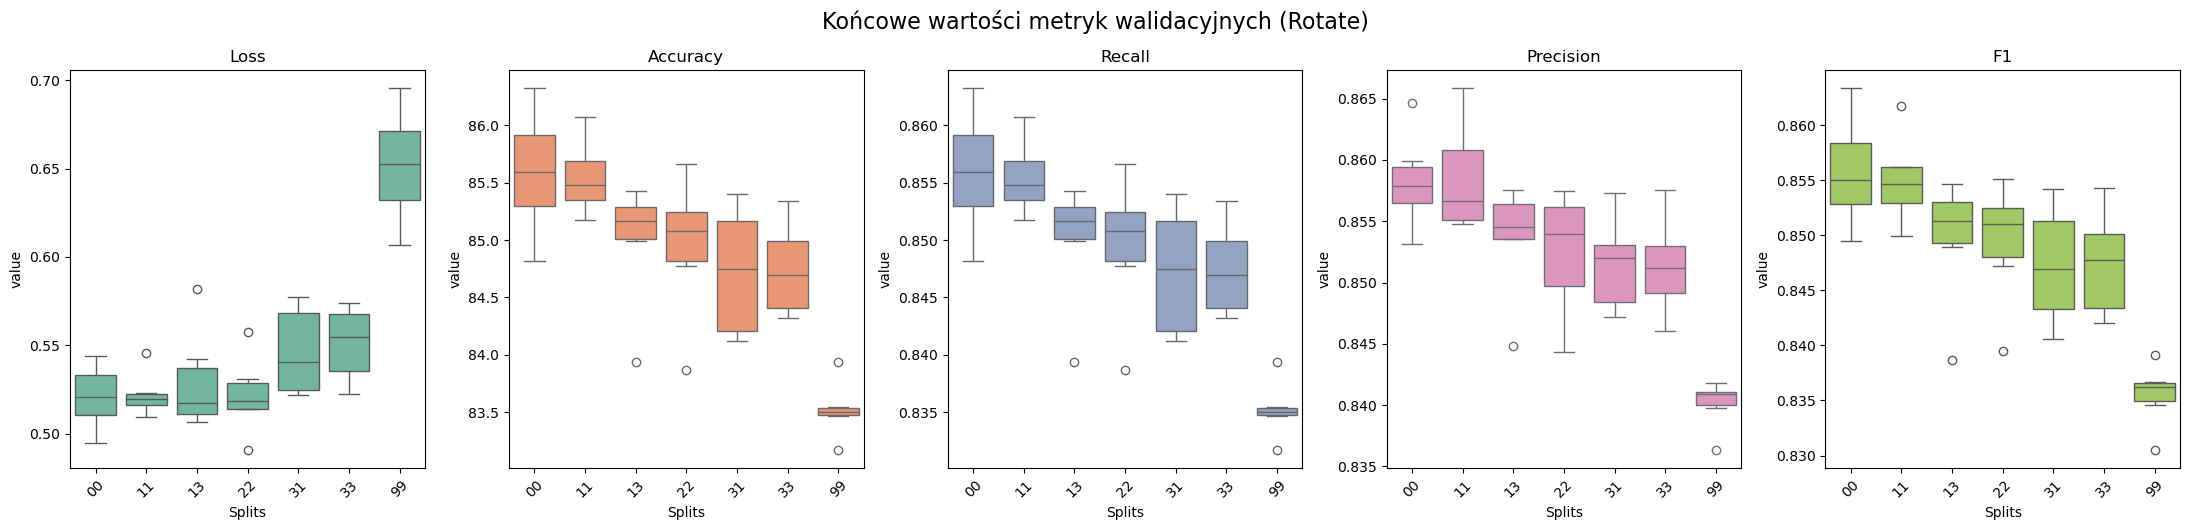

In [20]:
plot_metrics_per_augmentation()

In [36]:
def get_best_avg_dfs_for_all_augmentations():
    base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    augment_keywords = ['blur', 'brightness', 'flip', 'rotate', 'noise']

    best_dfs = {}

    for augmentation_keyword in augment_keywords:
        folder_dfs = {}

        for folder in os.listdir(base_path):
            if augmentation_keyword not in folder.lower():
                continue

            folder_path = os.path.join(base_path, folder)
            if not os.path.isdir(folder_path):
                continue

            val_dfs = []
            for fname in os.listdir(folder_path):
                if fname.endswith('val.csv'):
                    try:
                        df = pd.read_csv(os.path.join(folder_path, fname))
                        val_dfs.append(df)
                    except Exception as e:
                        print(f"Błąd podczas wczytywania {fname} w {folder}: {e}")

            if val_dfs:
                avg_df = pd.concat(val_dfs).groupby(level=0).mean().reset_index(drop=True)
                folder_dfs[folder] = avg_df

        if folder_dfs:
            best_folder = max(folder_dfs.items(), key=lambda x: x[1]['accuracy'].iloc[-1])[0]
            best_df = folder_dfs[best_folder]
            print(f"Wybrano folder: {best_folder} dla augmentacji '{augmentation_keyword}' z accuracy = {best_df['accuracy'].iloc[-1]:.4f}")
            best_dfs[augmentation_keyword] = best_df
        else:
            print(f"Brak danych dla augmentacji: {augmentation_keyword}")
            best_dfs[augmentation_keyword] = None

    # Obsługa folderu baseline
    baseline_dfs = []
    for folder in os.listdir(base_path):
        if 'baseline' not in folder.lower():
            continue

        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        for fname in os.listdir(folder_path):
            if fname.endswith('val.csv'):
                try:
                    df = pd.read_csv(os.path.join(folder_path, fname))
                    baseline_dfs.append(df)
                except Exception as e:
                    print(f"Błąd podczas wczytywania {fname} w {folder}: {e}")

    if baseline_dfs:
        avg_baseline_df = pd.concat(baseline_dfs).groupby(level=0).mean().reset_index(drop=True)
        print(f"Obliczono średnią dla baseline z accuracy = {avg_baseline_df['accuracy'].iloc[-1]:.4f}")
        best_dfs['baseline'] = avg_baseline_df
    else:
        print("Brak danych dla baseline.")
        best_dfs['baseline'] = None

    return best_dfs


In [37]:
best_dfs = get_best_avg_dfs_for_all_augmentations()

Wybrano folder: blur_99 dla augmentacji 'blur' z accuracy = 84.4517
Wybrano folder: brightness_11 dla augmentacji 'brightness' z accuracy = 84.3800
Wybrano folder: flip_00 dla augmentacji 'flip' z accuracy = 84.1150
Wybrano folder: rotate_00 dla augmentacji 'rotate' z accuracy = 85.5900
Wybrano folder: noise_13 dla augmentacji 'noise' z accuracy = 84.1083
Obliczono średnią dla baseline z accuracy = 83.8617


In [39]:
def plot_all_metrics_subplots(best_dfs):
    metrics = ['loss', 'accuracy', 'recall', 'precision', 'f1']
    augmentations = ['baseline', 'blur', 'brightness', 'flip', 'rotate', 'noise']
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'gray', 'olive']

    fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharex=True)

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for j, aug in enumerate(augmentations):
            df = best_dfs.get(aug)
            if df is not None and metric in df.columns:
                ax.plot(df[metric], label=aug, color=colors[j % len(colors)])
        
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.grid(True)
        ax.legend()

    fig.suptitle('Wykresy metryk dla najlepszych augmentacji', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

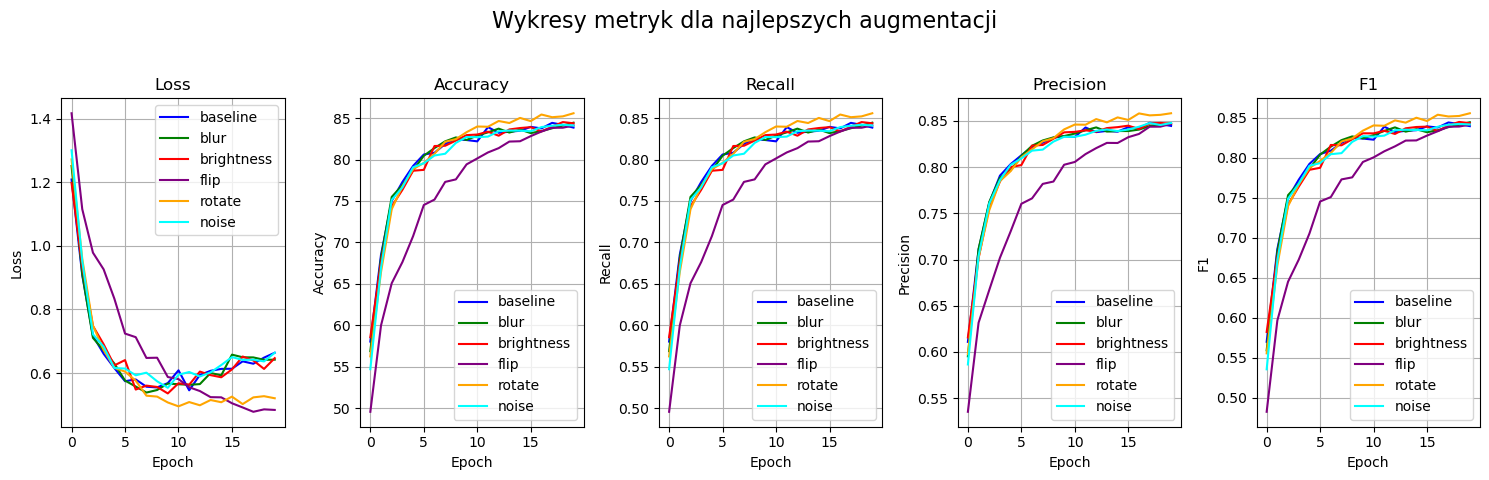

In [40]:
plot_all_metrics_subplots(best_dfs)